In [15]:

import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.ou import build_spread, ou_signal_on_spread, pair_ensemble_signal
from Models.zscore import zscore_signal_on_spread
from Models.trend import trend_signal
from Models.mining import mining_signal
from Backtest.metrics import build_summary_table, rolling_sharpe, sharpe_ratio
from Validation.monte_carlo import (
    iid_bootstrap_returns,
    block_bootstrap_returns,
    shuffled_sharpe_distribution,
    noise_injection_test,
    monte_carlo_report,
)

plt.style.use("default")


In [16]:

df = load_raw_crypto_csv(DATA_PATH)
df = df.loc["2017-11-12":].copy()

btc = df["BTC-USD_close"].astype(float)
eth = df["ETH-USD_close"].astype(float)

mask = (btc > 0) & (eth > 0)
mask &= (btc.pct_change().abs() < 1.0)
mask &= (eth.pct_change().abs() < 1.0)
df = df[mask].copy()
print("Rows:", len(df), df.index.min(), df.index.max())


Rows: 3008 2017-11-13 00:00:00 2026-02-09 00:00:00


In [17]:

def pair_portfolio_returns(df: pd.DataFrame, beta_window: int, position: pd.Series) -> pd.Series:
    log_b = np.log(df["BTC-USD_close"].astype(float))
    log_e = np.log(df["ETH-USD_close"].astype(float))

    minp = min(beta_window, max(30, beta_window // 3))
    cov = log_b.rolling(beta_window, min_periods=minp).cov(log_e)
    var = log_e.rolling(beta_window, min_periods=minp).var()
    beta = (cov / var).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    r_btc = df["BTC-USD_close"].astype(float).pct_change().fillna(0.0)
    r_eth = df["ETH-USD_close"].astype(float).pct_change().fillna(0.0)

    position = position.reindex(df.index).fillna(0.0)
    pnl = position.shift(1).fillna(0.0) * (r_btc - beta * r_eth)
    return pnl


def apply_turnover_cost(returns: pd.Series, position: pd.Series, fee_bps: float, slippage_bps: float) -> pd.Series:
    pos = position.reindex(returns.index).fillna(0.0)
    turnover = pos.diff().abs().fillna(0.0)
    cost_rate = (fee_bps + slippage_bps) / 1e4
    return returns - turnover * cost_rate


In [18]:

def walk_forward_splits(index: pd.DatetimeIndex, train_days: int, test_days: int, step_days: int):
    start = index.min()
    end = index.max()

    train_start = start
    train_end = start + pd.Timedelta(days=train_days)

    while True:
        test_start = train_end + pd.Timedelta(days=1)
        test_end = test_start + pd.Timedelta(days=test_days)
        if test_end > end:
            break

        yield (train_start, train_end, test_start, test_end)
        train_end = train_end + pd.Timedelta(days=step_days)


def simple_sharpe(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) < 100:
        return np.nan
    vol = r.std()
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(np.sqrt(365) * r.mean() / vol)


param_grid = {
    "beta_window": [180],
    "ou_window": [90],
    "entry_z": [1.25, 1.5],
    "exit_z": [0.2, 0.3, 0.5],
}

train_days = 365 * 2
test_days = 180
step_days = 180

splits = list(walk_forward_splits(df.index, train_days, test_days, step_days))
print("Num folds:", len(splits))

fold_rows = []
all_test_gross = pd.Series(0.0, index=df.index)
all_test_net = pd.Series(0.0, index=df.index)
all_test_pos = pd.Series(0.0, index=df.index)

for k, (tr0, tr1, te0, te1) in enumerate(splits, 1):
    train_df = df.loc[tr0:tr1].copy()
    test_df = df.loc[te0:te1].copy()

    best = None

    for beta_w in param_grid["beta_window"]:
        spread_tr = build_spread(train_df, beta_window=beta_w)

        for ou_w in param_grid["ou_window"]:
            for entry in param_grid["entry_z"]:
                for exit_ in param_grid["exit_z"]:
                    ou_tr = ou_signal_on_spread(spread_tr, window=ou_w, entry_z=entry, exit_z=exit_)
                    z_tr = zscore_signal_on_spread(spread_tr, window=max(60, ou_w), entry_z=entry, exit_z=exit_)

                    trend_tr = trend_signal(
                        pd.DataFrame({"spread": spread_tr}),
                        price_column="spread",
                        fast_window=20,
                        slow_window=max(90, ou_w),
                        long_only=False,
                        leverage_aggressive=1.0,
                        leverage_neutral=0.0,
                        leverage_defensive=-1.0,
                    )

                    mining_raw_tr = mining_signal(train_df)
                    mining_tr = (2.0 * mining_raw_tr - 1.0).reindex(spread_tr.index).fillna(0.0)

                    pos_tr = pair_ensemble_signal(
                        spread=spread_tr,
                        z_pos=z_tr,
                        trend_pos=trend_tr,
                        mining_pos=mining_tr,
                        w_ou=0.40,
                        w_z=0.30,
                        w_trend=0.20,
                        w_mining=0.10,
                        ou_window=ou_w,
                        ou_entry_z=entry,
                        ou_exit_z=exit_,
                        leverage_cap=1.0,
                    ).reindex(train_df.index).fillna(0.0)

                    gross_tr = pair_portfolio_returns(train_df, beta_window=beta_w, position=pos_tr)
                    net_tr = apply_turnover_cost(gross_tr, pos_tr, fee_bps=FEE_BPS, slippage_bps=SLIPPAGE_BPS)

                    s = simple_sharpe(net_tr)
                    if np.isnan(s):
                        continue

                    if (best is None) or (s > best["train_sharpe"]):
                        best = {
                            "fold": k,
                            "train_start": tr0,
                            "train_end": tr1,
                            "test_start": te0,
                            "test_end": te1,
                            "beta_window": beta_w,
                            "ou_window": ou_w,
                            "entry_z": entry,
                            "exit_z": exit_,
                            "train_sharpe": s,
                        }

    if best is None:
        best = {
            "fold": k,
            "train_start": tr0,
            "train_end": tr1,
            "test_start": te0,
            "test_end": te1,
            "beta_window": 180,
            "ou_window": 90,
            "entry_z": 1.5,
            "exit_z": 0.3,
            "train_sharpe": np.nan,
        }

    beta_w = best["beta_window"]
    spread_te = build_spread(test_df, beta_window=beta_w)

    z_te = zscore_signal_on_spread(spread_te, window=max(60, best["ou_window"]), entry_z=best["entry_z"], exit_z=best["exit_z"])
    trend_te = trend_signal(
        pd.DataFrame({"spread": spread_te}),
        price_column="spread",
        fast_window=20,
        slow_window=max(90, best["ou_window"]),
        long_only=False,
        leverage_aggressive=1.0,
        leverage_neutral=0.0,
        leverage_defensive=-1.0,
    )
    mining_raw_te = mining_signal(test_df)
    mining_te = (2.0 * mining_raw_te - 1.0).reindex(spread_te.index).fillna(0.0)

    pos_te = pair_ensemble_signal(
        spread=spread_te,
        z_pos=z_te,
        trend_pos=trend_te,
        mining_pos=mining_te,
        w_ou=0.40,
        w_z=0.30,
        w_trend=0.20,
        w_mining=0.10,
        ou_window=best["ou_window"],
        ou_entry_z=best["entry_z"],
        ou_exit_z=best["exit_z"],
        leverage_cap=1.0,
    ).reindex(test_df.index).fillna(0.0)

    gross_te = pair_portfolio_returns(test_df, beta_window=beta_w, position=pos_te)
    net_te = apply_turnover_cost(gross_te, pos_te, fee_bps=FEE_BPS, slippage_bps=SLIPPAGE_BPS)

    best["test_sharpe"] = simple_sharpe(net_te)

    fold_rows.append(best)
    all_test_gross.loc[test_df.index] = gross_te
    all_test_net.loc[test_df.index] = net_te
    all_test_pos.loc[test_df.index] = pos_te

wf_table = pd.DataFrame(fold_rows)
wf_table


Num folds: 12


,fold,train_start,train_end,test_start,test_end,beta_window,ou_window,entry_z,exit_z,train_sharpe,test_sharpe
0,1,2017-11-13,2019-11-13,2019-11-14,2020-05-12,180,90,1.5,0.3,0.085422,-0.494460
1,2,2017-11-13,2020-05-11,2020-05-12,2020-11-08,180,90,1.5,0.3,0.087502,-4.388594
2,3,2017-11-13,2020-11-07,2020-11-08,2021-05-07,180,90,1.5,0.3,0.138752,2.371247
3,4,2017-11-13,2021-05-06,2021-05-07,2021-11-03,180,90,1.5,0.3,-0.467595,-1.626163
4,5,2017-11-13,2021-11-02,2021-11-03,2022-05-02,180,90,1.5,0.2,-0.406811,-0.955060
5,6,2017-11-13,2022-05-01,2022-05-02,2022-10-29,180,90,1.5,0.2,-0.302193,3.618102
6,7,2017-11-13,2022-10-28,2022-10-29,2023-04-27,180,90,1.5,0.2,-0.345053,0.496504
7,8,2017-11-13,2023-04-26,2023-04-27,2023-10-24,180,90,1.5,0.2,-0.391979,-1.678522
8,9,2017-11-13,2023-10-23,2023-10-24,2024-04-21,180,90,1.5,0.2,-0.420145,-0.104279
9,10,2017-11-13,2024-04-20,2024-04-21,2024-10-18,180,90,1.5,0.2,-0.449669,-0.547720


In [19]:

summary = build_summary_table({
    "WF Pair Ensemble (Net)": {"returns": all_test_net.fillna(0.0), "position": all_test_pos.fillna(0.0)},
})

summary


,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
WF Pair Ensemble (Net),-0.274555,-0.210848,-0.02256,-0.254744,-0.088559,-0.020118,0.073275,3008,3.785904


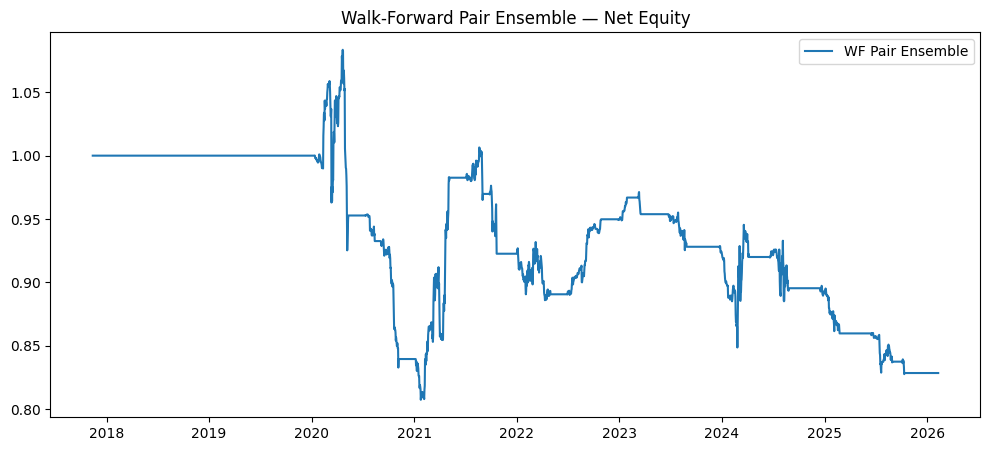

In [20]:

equity = (1.0 + all_test_net.fillna(0.0)).cumprod()

plt.figure(figsize=(12,5))
plt.plot(equity.index, equity.values, label="WF Pair Ensemble")
plt.title("Walk-Forward Pair Ensemble — Net Equity")
plt.legend()
plt.show()


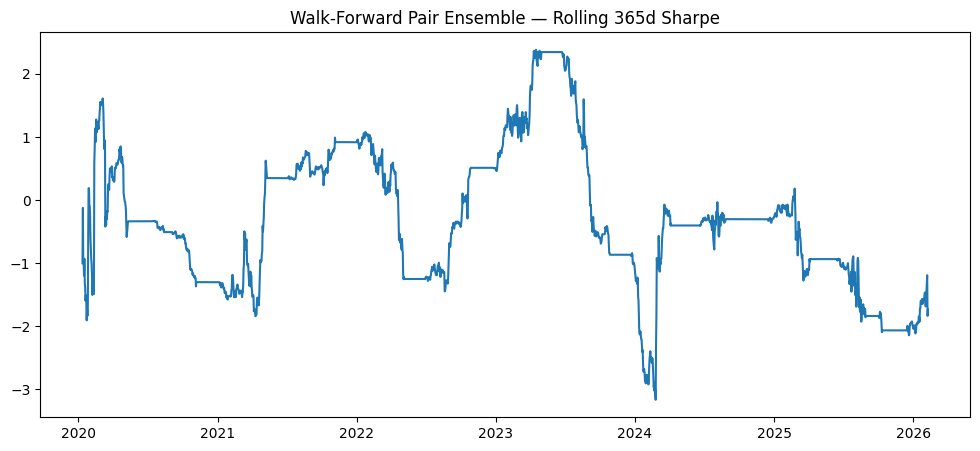

In [21]:

plt.figure(figsize=(12,5))
plt.plot(rolling_sharpe(all_test_net.fillna(0.0), window=365))
plt.title("Walk-Forward Pair Ensemble — Rolling 365d Sharpe")
plt.show()


In [22]:
r = all_test_net.dropna()
actual = sharpe_ratio(r)

iid_dist = iid_bootstrap_returns(r, n_samples=150)
block_dist = block_bootstrap_returns(r, block_size=20, n_samples=150)
shuffle_dist = shuffled_sharpe_distribution(r, n_samples=150)

print("Actual Sharpe:", actual)
print("IID mean Sharpe:", float(np.nanmean(iid_dist)))
print("Block mean Sharpe:", float(np.nanmean(block_dist)))
print("Shuffle mean Sharpe:", float(np.nanmean(shuffle_dist)))

Actual Sharpe: -0.2745550041217326
IID mean Sharpe: -0.31959656956237853
Block mean Sharpe: -0.2330867936412719
Shuffle mean Sharpe: -0.27455500412173267


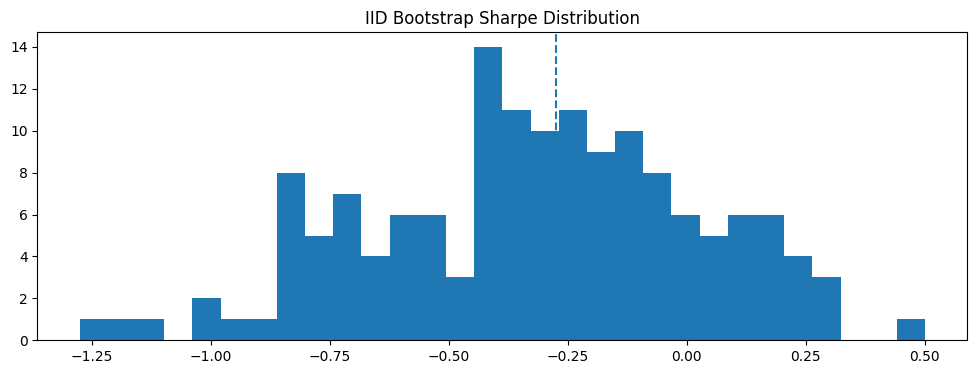

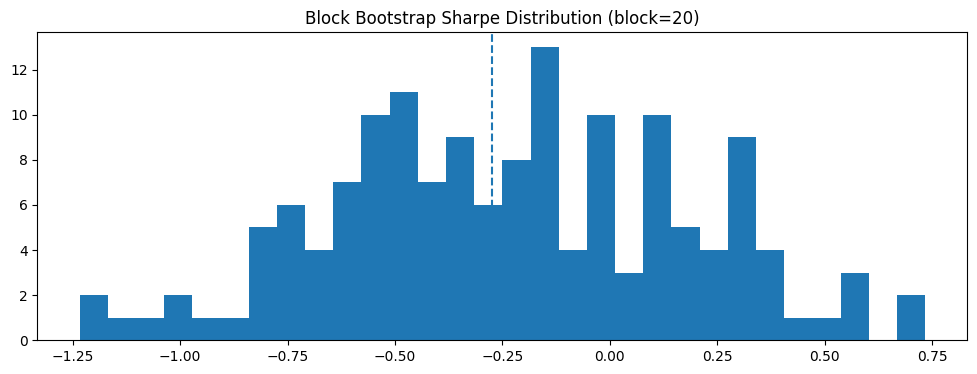

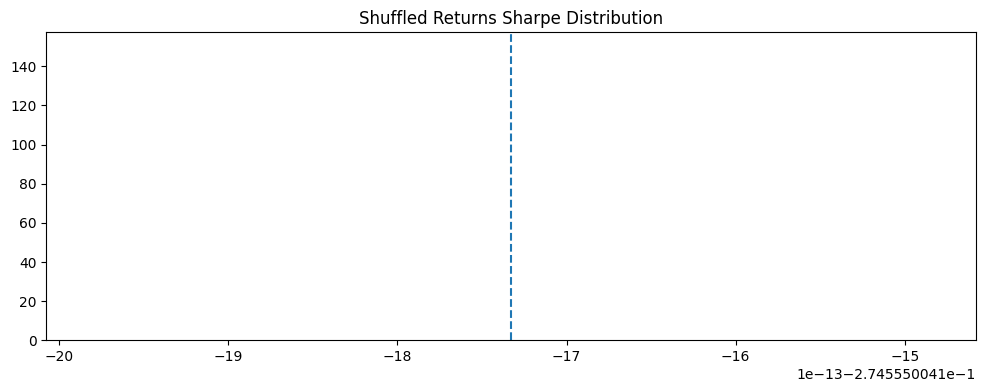

In [23]:

def _finite(x):
    x = np.asarray(x, dtype=float)
    return x[np.isfinite(x)]

def bins_for_hist(arr, max_bins=40, min_bins=10):
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 1
    # If data range is zero, only one bin is valid
    if np.nanmax(a) == np.nanmin(a):
        return 1
    uniq = np.unique(a)
    if uniq.size <= 1:
        return 1
    n = min(max_bins, max(min_bins, len(a) // 5))
    return max(1, min(n, uniq.size))

def safe_hist(arr, **kwargs):
    a = np.asarray(arr, dtype=float)
    b = bins_for_hist(a)
    try:
        plt.hist(a, bins=b, **kwargs)
    except ValueError:
        # fallback to single bin if histogram creation fails
        plt.hist(a, bins=1, **kwargs)

iid_f = _finite(iid_dist)
block_f = _finite(block_dist)
shuffle_f = _finite(shuffle_dist)

plt.figure(figsize=(12,4))
safe_hist(iid_f)
plt.axvline(actual, linestyle="--")
plt.title("IID Bootstrap Sharpe Distribution")
plt.show()

plt.figure(figsize=(12,4))
safe_hist(block_f)
plt.axvline(actual, linestyle="--")
plt.title("Block Bootstrap Sharpe Distribution (block=20)")
plt.show()

plt.figure(figsize=(12,4))
safe_hist(shuffle_f)
plt.axvline(actual, linestyle="--")
plt.title("Shuffled Returns Sharpe Distribution")
plt.show()


In [24]:
def prob_overfit(actual_sharpe, dist):
    return float(np.mean(dist >= actual_sharpe))

print("P(overfit) IID:", prob_overfit(actual, iid_dist))
print("P(overfit) Block:", prob_overfit(actual, block_dist))
print("P(overfit) Shuffle:", prob_overfit(actual, shuffle_dist))

P(overfit) IID: 0.48
P(overfit) Block: 0.5333333333333333
P(overfit) Shuffle: 0.4066666666666667


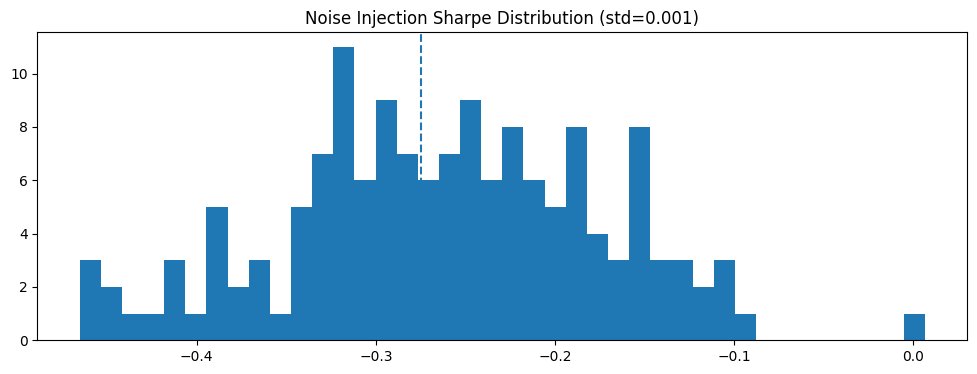

Noise mean Sharpe: -0.26227056049898123
P(noise >= actual): 0.5333333333333333


In [25]:
noise_dist = noise_injection_test(r, noise_std=0.001, n_samples=150)

plt.figure(figsize=(12,4))
plt.hist(noise_dist, bins=40)
plt.axvline(actual, linestyle="--")
plt.title("Noise Injection Sharpe Distribution (std=0.001)")
plt.show()

print("Noise mean Sharpe:", float(np.nanmean(noise_dist)))
print("P(noise >= actual):", float(np.mean(noise_dist >= actual)))

In [26]:
def recompute_net_with_costs(fee_bps, slip_bps):
    net = apply_turnover_cost(all_test_gross, all_test_pos, fee_bps=fee_bps, slippage_bps=slip_bps)
    return net

cost_cases = {
    "0 bps": (0.0, 0.0),
    "10 bps": (10.0, 0.0),
    "20 bps": (10.0, 10.0),
}

rows = []
for name, (fee, slip) in cost_cases.items():
    net = recompute_net_with_costs(fee, slip)
    s = build_summary_table({name: {"returns": net.fillna(0.0), "position": all_test_pos}}).iloc[0].to_dict()
    rows.append({"CostCase": name, **s})

pd.DataFrame(rows).set_index("CostCase")

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
CostCase,,,,,,,,,
0 bps,-0.199399,-0.151617,-0.017151,-0.251602,-0.068167,-0.014603,0.073236,3008.0,3.785904
10 bps,-0.251017,-0.193743,-0.020867,-0.253772,-0.082226,-0.018389,0.073258,3008.0,3.785904
20 bps,-0.302531,-0.233992,-0.024570,-0.255937,-0.095999,-0.022175,0.073298,3008.0,3.785904


In [27]:
wf_table[["fold","beta_window","ou_window","entry_z","exit_z","train_sharpe","test_sharpe"]]

,fold,beta_window,ou_window,entry_z,exit_z,train_sharpe,test_sharpe
0,1,180,90,1.5,0.3,0.085422,-0.494460
1,2,180,90,1.5,0.3,0.087502,-4.388594
2,3,180,90,1.5,0.3,0.138752,2.371247
3,4,180,90,1.5,0.3,-0.467595,-1.626163
4,5,180,90,1.5,0.2,-0.406811,-0.955060
5,6,180,90,1.5,0.2,-0.302193,3.618102
6,7,180,90,1.5,0.2,-0.345053,0.496504
7,8,180,90,1.5,0.2,-0.391979,-1.678522
8,9,180,90,1.5,0.2,-0.420145,-0.104279
9,10,180,90,1.5,0.2,-0.449669,-0.547720


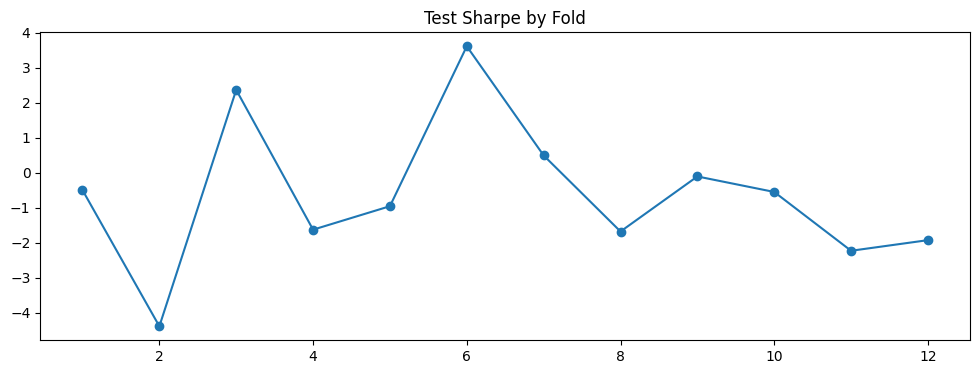

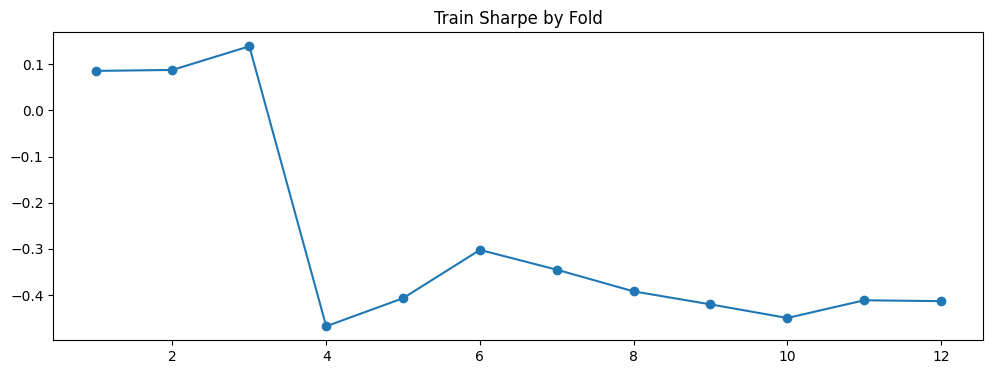

In [28]:
plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["test_sharpe"], marker="o")
plt.title("Test Sharpe by Fold")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(wf_table["fold"], wf_table["train_sharpe"], marker="o")
plt.title("Train Sharpe by Fold")
plt.show()

In [29]:
turnover = all_test_pos.diff().abs().fillna(0.0)
annual_turnover = float(turnover.sum() / len(turnover) * 365)

print("Annual turnover:", annual_turnover)

Annual turnover: 3.785904255319149


In [30]:
report = monte_carlo_report(r, n_samples=150, block_size=20)

robust_summary = {
    "ActualSharpe": report["ActualSharpe"],
    "ProbOverfit_Block": report["ProbOverfit_Block"],
    "ProbOverfit_Shuffle": report["ProbOverfit_Shuffle"],
    "AnnualTurnover": annual_turnover,
}

robust_summary

{'ActualSharpe': -0.2745550041217326,
 'ProbOverfit_Block': 0.5133333333333333,
 'ProbOverfit_Shuffle': 0.47333333333333333,
 'AnnualTurnover': 3.785904255319149}

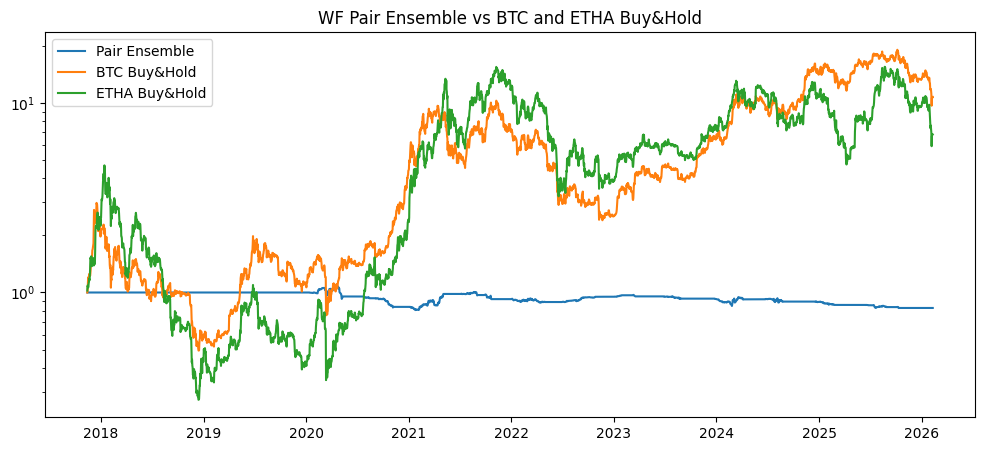

In [31]:
etha = pd.read_csv('../../Market Data/Crypto Data/ETHA.csv')
etha['Date'] = pd.to_datetime(etha['Start'])
etha = etha.sort_values('Date').set_index('Date')
etha_close = pd.to_numeric(etha['Close'], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

btc_bh = df['BTC-USD_close'].astype(float).pct_change().fillna(0.0)
etha_bh = etha_close.pct_change().reindex(df.index).fillna(0.0)

ensemble_eq = (1.0 + all_test_net.fillna(0.0)).cumprod()
btc_eq = (1.0 + btc_bh).cumprod()
etha_eq = (1.0 + etha_bh).cumprod()

plt.figure(figsize=(12,5))
plt.plot(ensemble_eq.index, ensemble_eq.values, label='Pair Ensemble')
plt.plot(btc_eq.index, btc_eq.values, label='BTC Buy&Hold')
plt.plot(etha_eq.index, etha_eq.values, label='ETHA Buy&Hold')
plt.yscale('log')
plt.title('WF Pair Ensemble vs BTC and ETHA Buy&Hold')
plt.legend()
plt.show()
